# Importing data

In [3]:
import pandas as pd
import re
import nltk
import contractions
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.sparse import hstack
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Downloading package omw-1.4 to /home/vanshv/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanshv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vanshv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df_train = pd.read_csv("mis_assessment-data/mis_assessment/train3.csv")
df_test = pd.read_csv("mis_assessment-data/mis_assessment/test3.csv")

df_train = df_train.rename(columns = {'Text': 'text'})
df_test = df_test.rename(columns = {'Text': 'text'})
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split(" ")))

print(df_train.head())

                                                text  category  word_count
0  when modi promised “minimum government maximum...      -1.0          33
1  talk all the nonsense and continue all the dra...       0.0          14
2  what did just say vote for modi  welcome bjp t...       1.0          23
3  asking his supporters prefix chowkidar their n...       1.0          34
4  answer who among these the most powerful world...       1.0          15


# Preprocessing and EDA

## Nan Values and Duplicate Values Removal

In [5]:
print(f"Nan Values before removal {df_train.isna().sum().sum()}, Duplicate Values before removal {df_train.duplicated().sum()}")
df_train = df_train.dropna()
df_train = df_train.drop_duplicates(subset='text').reset_index(drop=True)
print(f"Nan Values before removal {df_train.isna().sum().sum()}, Duplicate Values after removal {df_train['text'].duplicated().sum()})")

Nan Values before removal 17397, Duplicate Values before removal 8696
Nan Values before removal 0, Duplicate Values after removal 0)


In [6]:
df_train[df_train['word_count'] == 12].duplicated().sum()


np.int64(0)

In [7]:
df_train.value_counts('category')

category
 1.0    68228
 0.0    52317
-1.0    33732
Name: count, dtype: int64

## URL Removal

In [8]:
url_count = 0

regex_tokenizer = RegexpTokenizer('/', gaps = True)
def join_and_split(words):
   return ((" ").join(words)).split()

df_train['text'] = df_train['text'].apply(regex_tokenizer.tokenize)
df_train['text'] = df_train['text'].apply(join_and_split)
# df_test['text'] = df_test['text'].apply(regex_tokenizer.tokenize)
# df_test['text'] = df_test['text'].apply(join_and_split)

def get_words_from_urls(words):
    global url_count
    clean_sentence = ""
    for word in words:
        if word[:4] == 'http' or word[:3] == 'www':
          url_count += 1
          continue
        clean_sentence += word + " "
    return clean_sentence

df_train['text'] = df_train['text'].apply(get_words_from_urls)
# df_test['text'] = df_test['text'].apply(get_words_from_urls)
print(url_count)

31


## Expanding contractions

In [9]:
df_train['text'] = df_train['text'].apply(contractions.fix)
# df_test['text'] = df_test['text'].apply(contractions.fix)

## Lemmatization

In [10]:
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

# we do not convert the sentences to lowercase, because lowercase and uppercase words might have different connotations
def lemmatize_sentence(tokenized_list):
    lemmatized_list = [lemmatizer.lemmatize(word) if len(word) > 4 else word for word in tokenized_list]
    lemmatized_s = ' '.join([str(word) for word in lemmatized_list])
    return lemmatized_s

df_train['text'] = df_train['text'].apply(word_tokenize)
df_train['text'] = df_train['text'].apply(lemmatize_sentence)

# df_test['text'] = df_test['text'].apply(word_tokenize)
# df_test['text'] = df_test['text'].apply(lemmatize_sentence)

[nltk_data] Downloading package punkt_tab to /home/vanshv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Removing Punctuation

In [11]:
df_train['text'] = df_train['text'].str.strip()
df_train['text'] = df_train['text'].apply(lambda x : re.sub('[^a-zA-Z ?!]+', '', x))
df_train['text'] = df_train['text'].str.replace(r'\s+', ' ', regex=True)
# df_test['text'] = df_test['text'].apply(lambda x : re.sub('[^a-zA-Z ?!]+', '', x))

## Removing Duplicates

In [12]:
df_train = df_train.drop_duplicates(subset='text').reset_index(drop=True)


## Generating Wordclouds

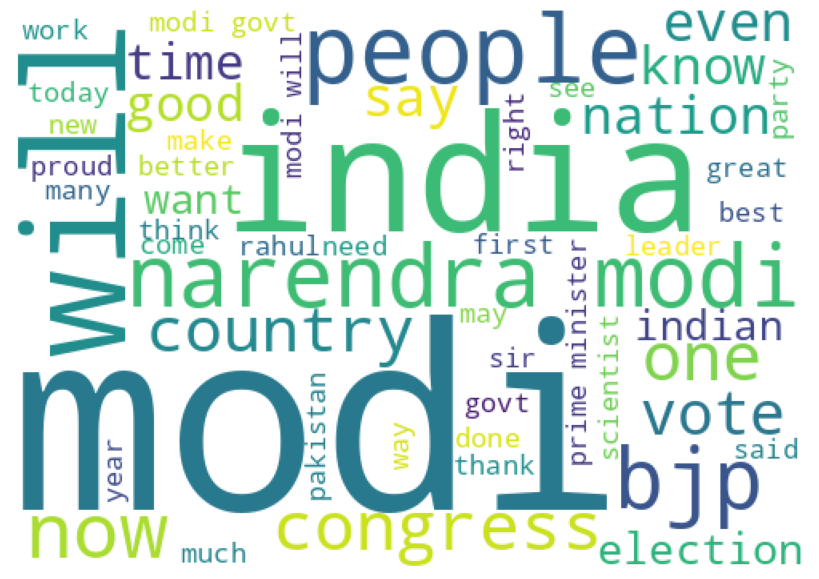

In [13]:
pos_df = df_train[df_train['category'] == 1]
pos_df = pos_df['text']
pos_df = pos_df.str.cat(sep=' ')
neg_df = df_train[df_train['category'] == -1]
neg_df = neg_df['text']
neg_df = neg_df.str.cat(sep=' ')
neu_df = df_train[df_train['category'] == 0]
neu_df = neu_df['text']
neu_df = neu_df.str.cat(sep=' ')

stopwords = set(STOPWORDS)


wordcloud = WordCloud(width = 500, height = 350,
                background_color ='white',
                stopwords=stopwords,
                min_font_size = 12).generate(pos_df)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

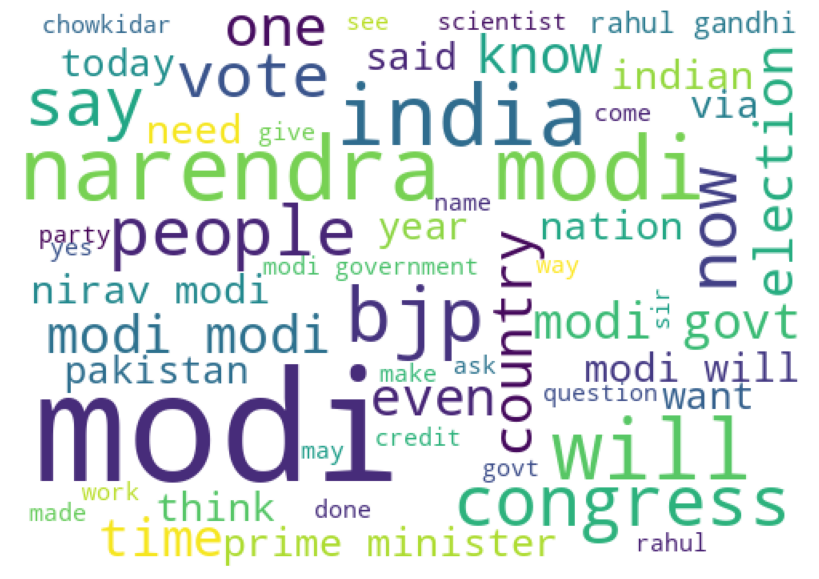

In [14]:
wordcloud = WordCloud(width = 500, height = 350,
                background_color ='white',
                stopwords=stopwords,
                min_font_size = 12).generate(neu_df)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

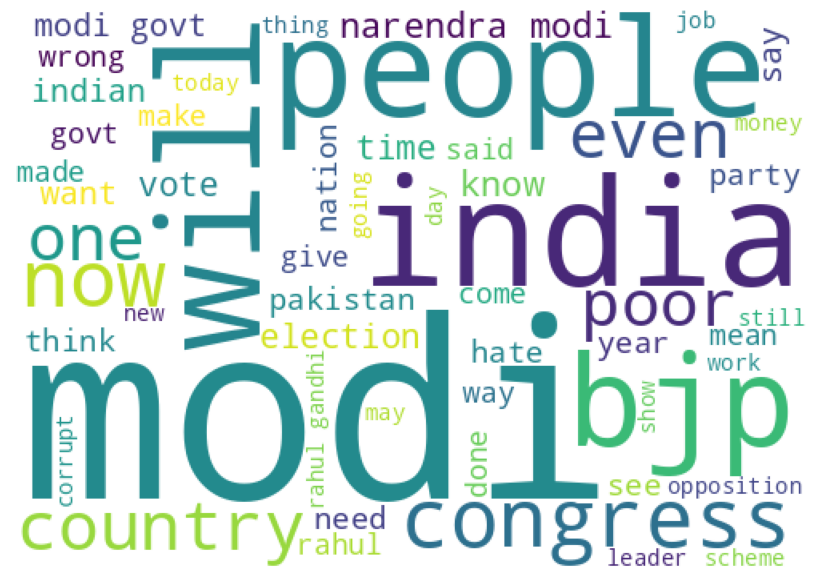

In [15]:
wordcloud = WordCloud(width = 500, height = 350,
                background_color ='white',
                stopwords=stopwords,
                min_font_size = 12).generate(neg_df)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Word count Histogram

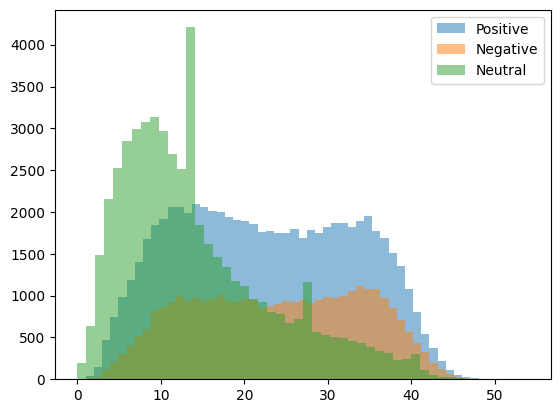

In [16]:
pos_df = df_train[df_train['category'] == 1]
pos_df = pos_df['text']
neg_df = df_train[df_train['category'] == -1]
neg_df = neg_df['text']
neu_df = df_train[df_train['category'] == 0]
neu_df = neu_df['text']

def get_text_length(text):
    return len(text.split())

pos_df = pos_df.apply(get_text_length)
neg_df = neg_df.apply(get_text_length)
neu_df = neu_df.apply(get_text_length)

plt.hist(pos_df, bins = 50, alpha = 0.5, label = 'Positive')
plt.hist(neg_df, bins = 50, alpha = 0.5, label = 'Negative')
plt.hist(neu_df, bins = 50, alpha = 0.5, label = 'Neutral')
plt.legend(loc='upper right')
plt.show()

## Vectorization

In [17]:
train_comments = df_train["text"]
# test_comments = df_test["text"]

all_comments = pd.concat([train_comments])

all_comments.shape
all_comments.head()

0    when modi promised minimum government maximum ...
1    talk all the nonsense and continue all the dra...
2    what did just say vote for modi welcome bjp to...
3    asking his supporter prefix chowkidar their na...
4    answer who among these the most powerful world...
Name: text, dtype: object

In [18]:
mf = 10000

vectorizer = TfidfVectorizer(sublinear_tf = True,
                             strip_accents = 'unicode',
                             analyzer = 'word',
                             token_pattern = '(?u)\\b\\w\\w+\\b\\w{,1}',
                             lowercase = True,
                             stop_words = 'english',
                             ngram_range = (1, 2),
                             min_df = 2,
                             max_df = 0.6,
                             norm = 'l2',
                             max_features = int((3/5)*mf)
                             )
vectorizer.fit(all_comments)
train_word_features = vectorizer.transform(train_comments)
# test_word_features = vectorizer.transform(test_comments)

char_vectorizer = TfidfVectorizer (sublinear_tf = True,
                                   strip_accents = 'unicode',
                                   analyzer = 'char',
                                   ngram_range = (2, 6),
                                   min_df = 2,
                                   max_df = 0.6,
                                   max_features = int((2/5)*mf)
                                   )
char_vectorizer.fit(all_comments)
train_char_features = char_vectorizer.transform(train_comments)
# test_char_features = char_vectorizer.transform(test_comments)

train_features = hstack([train_word_features, train_char_features])
# test_features = hstack([test_word_features, test_char_features])

# Train Test Split

In [19]:
from scipy.sparse import csr_matrix, hstack

word_count_array = df_train['word_count'].to_numpy()
word_count_array = word_count_array.reshape(-1, 1)
word_count_sparse = csr_matrix(word_count_array)
X = hstack([train_features, word_count_sparse])
# X = train_features

y = df_train['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30698568 stored elements and shape (121124, 10001)>

# Training

## Linear Regression

In [20]:
reg = LinearRegression().fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_train = [1 if x > 0.5 else -1 if x < -0.5 else 0 for x in y_pred_train]
y_pred_test = reg.predict(X_test)
y_pred_test = [1 if x > 0.5 else -1 if x < -0.5 else 0 for x in y_pred_test]

def get_acc(y_pred, y):
    total_preds = len(y_pred)
    correct_preds = 0
    for i in range(total_preds):
        if y_pred[i] == y.iloc[i]:
            correct_preds += 1
    return correct_preds/total_preds
print(f"Training Accuracy : {get_acc(y_pred_train, y_train)}")
print(f"Validation Accuracy : {get_acc(y_pred_test, y_test)}")

Training Accuracy : 0.7478039034377992
Validation Accuracy : 0.7181400878438625


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
print(f"Training Accuracy : {clf.score(X_train, y_train)}")
print(f"Validation Accuracy : {clf.score(X_test, y_test)}")

/home/vanshv/Code/mis-assessment/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
reg = clf
y_pred_train = reg.predict(X_train)
y_pred_train = [1 if x > 0.5 else -1 if x < -0.5 else 0 for x in y_pred_train]
y_pred_test = reg.predict(X_test)
y_pred_test = [1 if x > 0.5 else -1 if x < -0.5 else 0 for x in y_pred_test]

def get_acc(y_pred, y):
    total_preds = len(y_pred)
    correct_preds = 0
    for i in range(total_preds):
        if y_pred[i] == y.iloc[i]:
            correct_preds += 1
    return correct_preds/total_preds
print(f"Training Accuracy : {get_acc(y_pred_train, y_train)}")
print(f"Validation Accuracy : {get_acc(y_pred_test, y_test)}")